#  Model Order Selection for Neural Data



**Name**: Neeraja Narayanswamy

**Net ID**: nn2108

**Attribution**: This notebook is a slightly adapted version of the [model order selection lab assignment](https://github.com/sdrangan/introml/blob/master/unit04_model_sel/lab_neural_partial.ipynb) by Prof. Sundeep Rangan.

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain.  In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces.  In this notebook, you will use model selection for performing some simple analysis on real neural signals.  

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand motion from the neural signals from the motor cortex.

We first load the key packages.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  However, the raw data files can be quite large.  To make the lab easier, the [Kording lab](http://kordinglab.com/) at UPenn has put together an excellent [repository](https://github.com/KordingLab/Neural_Decoding) where they have created simple pre-processed versions of the data.  You can download the file `example_data_s1.pickle` from the [Dropbox link](https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=0).  Alternatively, you can directly run the following command.  This may take a little while to download since the file is 26 MB.

In [ ]:
!wget 'https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1' -O example_data_s1.pickle

--2020-07-04 15:17:15--  https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle [following]
--2020-07-04 15:17:16--  https://www.dropbox.com/sh/dl/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccd509c41074b0107a6357c3a10.dl.dropboxusercontent.com/cd/0/get/A66R3KeD0lnSobljZeoL8-P_YaXdTtNsqBHU0yd3BQbW74R7c4A30eNIlw_xRQdWfjT9HrP6ijisc0Bgq3z3LtfCBbHJcDwCsWbtmdDSggkAng/file?dl=1# [following]
--2020-07-04 15:17:16--  https://uccd509c41074b0107a6357c3a10.dl.dropboxusercontent.com/cd/0/get/A66R3KeD0lnSobljZeoL8-

The file is a *pickle* data structure, which uses the Python package `pickle` to serialize Python objects into data files.  Once you have downloaded the file, you can run the following command to retrieve the data from the pickle file.

In [ ]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

The matrix `X` is matrix of spike counts from different neurons, where `X[i,j]` is the number of spikes from neuron `j` in time bin `i`.

The matrix `y` has two columns:
* `y[i,0] = ` velocity of the monkey's hand in the x-direction
* `y[i,1] = ` velocity of the monkey's hand in the y-direction
Our goal will be to predict `y` from `X`.  

Each time bin represent `tsamp=0.05` seconds of time.  Using `X.shape` and `y.shape`, we can compute and print:
* `nt = ` the total number of time bins
* `nneuron = ` the total number of neurons
* `nout = ` the total number of output variables to track = number of columns in `y`
* `ttotal = ` total time of the experiment is seconds. 

In [ ]:
tsamp = 0.05  # sampling time in seconds

nt, nneuron = X.shape
nout = y.shape[1]
ttotal = nt*tsamp

print('Number of neurons = %d' % nneuron)
print('Number of time samples = %d' % nt)
print('Number of outputs = %d' % nout)
print('Total time (secs) = %f' % ttotal)

Number of neurons = 52
Number of time samples = 61339
Number of outputs = 2
Total time (secs) = 3066.950000


Then, we can plot the velocity against time, for each direction, for the first few minutes:

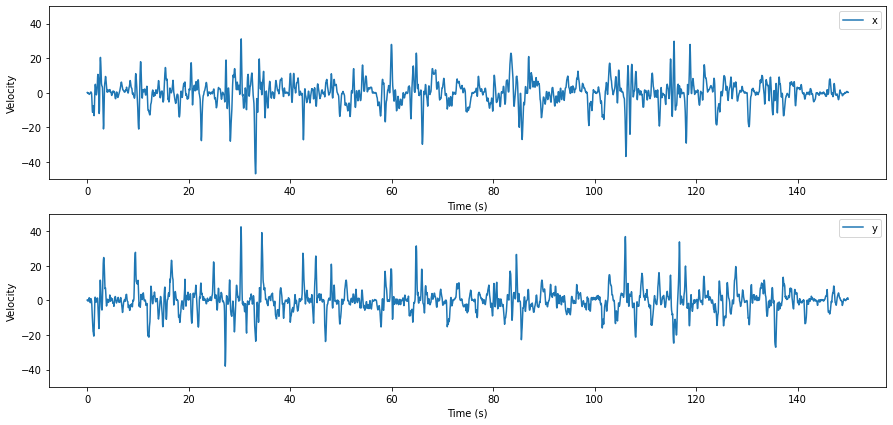

In [ ]:
t_cutoff = 3000
directions = ['x', 'y']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,7))
for n in range(nout):
  sns.lineplot(np.arange(0, t_cutoff)*tsamp, y[0:t_cutoff, n], label=directions[n], ax=axes[n]);

  axes[n].set_ylabel("Velocity")
  axes[n].set_xlabel("Time (s)")
  axes[n].set_ylim(-50,50)

Then, we can "zoom in" on a small slice of time in which the monkey is moving the hand, and see the neural activity at the same time.

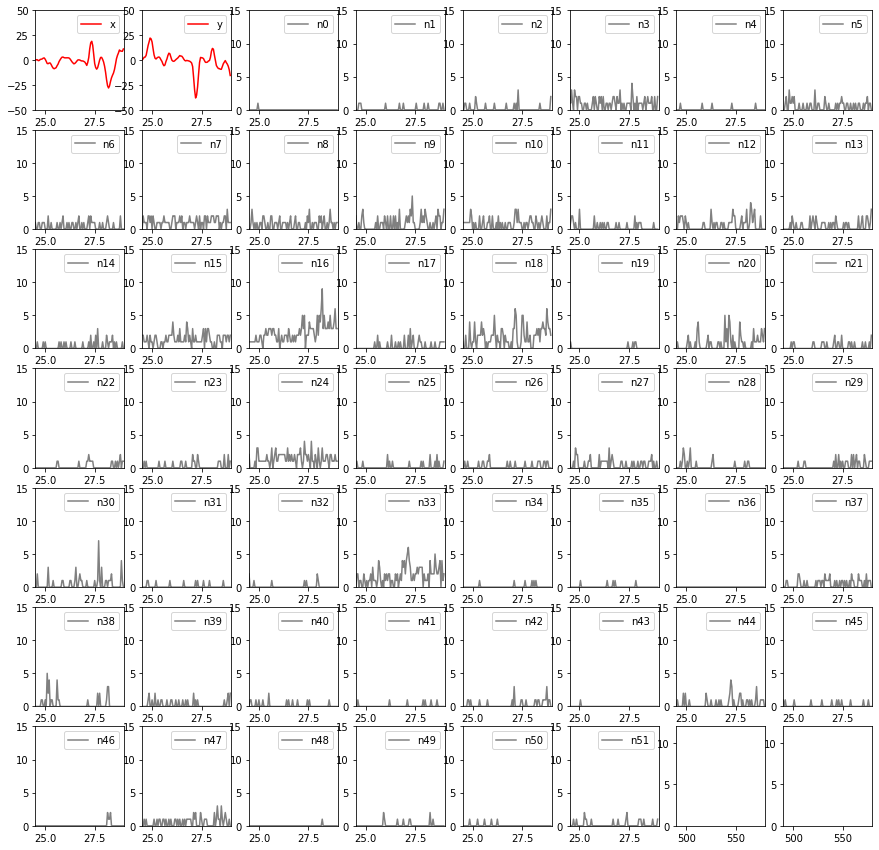

In [ ]:
t_start = 490
t_end = 580

fig, axes = plt.subplots(nrows=7, ncols=8, figsize=(15,15))

# Setting the range for all axes
plt.setp(axes, xlim=(t_start, t_end), ylim=(0,12));

for n in range(nout):
  sns.lineplot(np.arange(t_start, t_end)*tsamp, y[t_start:t_end, n], ax=axes[n//2,n%2], color='red', label=directions[n])
  plt.setp(axes[n//2,n%2], xlim=(t_start*tsamp, t_end*tsamp), ylim=(-50, +50));

for n in range(nneuron):
  sns.lineplot(np.arange(t_start, t_end)*tsamp, X[t_start:t_end, n], ax=axes[(n+2)//8,(n+2)%8], label="n%d" % n, color='grey')
  plt.setp(axes[(n+2)//8,(n+2)%8], xlim=(t_start*tsamp, t_end*tsamp), ylim=(0, +15));



## Fitting a simple linear model

Let's first try a simple linear regression model to fit the data.

To start, we will split the data into a training set and a test set. We'll fit the model on the training set and then use the test set to estimate the model performance on new, unseen data.

**To shuffle or not to shuffle?**

The `train_test_split` function has an optional `shuffle` argument. 


*   If you use `shuffle=False`, then `train_test_split` will take the first part of the data as the training set and the second part of the data as the test set, according to the ratio you specify in `test_size` or `train_size`.
*   If you use `shuffle=True`, then `train_test_split` will first randomly shuffle the data. Then, it will take the first part of the *shuffled* data as the training set and the second part of the *shuffled* data as the test set, according to the ratio you specify in `test_size` or `train_size`.

According to the function [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), by default, `shuffle` is `True`: 

> **shuffle: bool, default=True**
> 
> Whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

so if you do not specify anything related to `shuffle`, your data will be randomly shuffled before it is split into training and test data.

Under what conditions should you shuffle data? Suppose your dataset includes samples of a medical experiment on 1000 subjects, and the first 500 samples in the data are from male subjects while the second 500 samples are from female subjects. If you set `shuffle=False`, then your training set would have a much higher proportion of male subjects than your test set (with the specific numbers depending on the ratio you specify).

On the other hand, suppose your dataset includes stock prices at closing time, with each sample representing a different date (in order). If you allow `train_test_split` to shuffle the data, then your model will be allowed to "learn" stock prices using prices from the day *after* the one it is trying to predict! Obviously, your model won't be able to learn from future dates in production, so it shouldn't be allowed to in the evaluation stage, either. (Predicting the past using the future is considered a type of data leakage.)

With this in mind, it is usually inappropriate to shuffle time series data when splitting it up into smaller sets for training, validation, or testing. 

(There are more sophisticated ways to handle splitting time series data, but for now, splitting it up the usual way, just without shuffling first, will suffice.)


Given the discussion above, use the `train_test_split` function to split the data into training and test sets, but with no shuffling.  Let `Xtr,ytr` be the training data set and `Xts,yts` be the test data set.  Use `test_size=0.33` so 1/3 of the data is used for evaluating the model performance.

In [ ]:
# TODO 1
Xtr, Xts, ytr, yts = train_test_split(X,y,test_size = 0.33)


Now, fit a linear regression on the training data `Xtr,ytr`.  Make a prediction  `yhat` using the test data, `Xts`.  Compare `yhat` to `yts` to measure `rsq`, the  R2 value.  You can use the `r2_score` method. Print the `rsq` value.  You should get `rsq` of around `0.45`. 

In [ ]:
# TODO 2
# yhat = ...
# rsq = ...

It is useful to plot the predicted vs. actual values. Since we have two predicted values for each sample - the velocity in the X direction and the velocity in the Y direction - you should make two subplots, 

* one of predicted X direction vs. actual X direction,
* one of predicted Y direction vs. actual Y direction 

In [ ]:
# TODO 3

## Fitting a model with delay



One way we can improve the model accuracy is to add features using delayed version of the existing features.  

Specifically, the model we used above tries to predict velocity in direction $k$ at time $i$ using

$$\hat{y}_{i,k} = w_{k,0} + \sum_{d=1}^{\text{nneuron}} w_{k,d} X_{i,d}  $$

In this model, $\hat{y}_{i,k}$ at the $i$th time bin was only dependent on  $X_i$, the number of spikes of each neuron in time bin $i$.  In signal processing, this is called a *memoryless* model.  

However, in many physical systems, such as those that arise in neuroscience, there is a delay between the inputs and outputs.  To model this effect, we could add additional features to each row of data, representing the number of spikes of each neuron in the *previous* row. Then, the output at time $i$ would be modeled as the effect of the neurons firing in time $i$ _and_ the effect of the neurons firing in time $i-1$. 

We wouldn't be able to use data from the past for the first row of data, since we don't _have_ data about neurons firing in the previous time step. But we can drop that row. If our original data matrix had `nt` rows and `nneuron` columns, our data matrix with delayed features would have `nt - 1` rows and `nneuron + 1 x nneuron` columns. (The first `nneuron` columns represent the number of spikes in each neuron for the current time, the next `nneuron` columns represent the number of spikes in each neuron for the previous time.)

Furthermore, we can "look back" any number of time steps, so that the output at time $i$ is modeled as the effect of the neurons firing in time $i$, the neurons firing in time $i-1$, ..., all the way up to the effect of the neurons firing in time $i- \text{dly}$ (where $\text{dly}$ is the maximum number of time steps we're going to "look back" on). Our data matrix with the additional delayed features would have `nt - dly` rows and `nneuron + dly x nneuron` columns.


Here is a function that accepts `X` and `y` data and a `dly` argument, and returns `X` and `y` with delayed features up to `dly` time steps backward.

In [ ]:
def create_dly_data(X,y,dly):
    """
    Create delayed data
    """    
    n,p = X.shape
    Xdly = np.zeros((n-dly,(dly+1)*p))
    for i in range(dly+1):
        Xdly[:,i*p:(i+1)*p] = X[dly-i:n-i,:]
    ydly = y[dly:]
    
    return Xdly, ydly


To convince yourself that this works, try creating a data matrix that includes delayed features one time step back:

In [ ]:
X_dly1, y_dly1 = create_dly_data(X, y, 1)

Verify that the dimensions have changed, as expected:

In [ ]:
# dimensions of original data matrix
X.shape

In [ ]:
# dimensions of data matrix with delayed features 1 time step back
X_dly1.shape

Check row 0 in the matrix with delayed features, and verify that it is the concatenation of row 1 and row 0 in the original data matrix. (Note that row 0 in the matrix with delayed features corresponds to row 1 in the original data matrix.)

In [ ]:
X_dly1[0]

In [ ]:
y_dly1[0]

In [ ]:
np.hstack((X[1], X[0]))

In [ ]:
y[1]

Now fit an linear delayed model with `dly=2` delay lags.  That is,
* Create delayed data `Xdly,ydly=create_dly_data(X,y,dly=2)`
* Split the data into training and test as before
* Fit the model on the training data
* Measure the `R^2` score on the test data

If you did this correctly, you should get a new `R^2` score around 0.60.  This is significantly better than the memoryless models.

In [ ]:
# TODO 4

# Create the delayed data

# Split into training and test

# Create linear regression object

# Fit the model

# Measure the new r2 score


Plot the predicted vs. true values as before, with one subplot for. You should visually see a better fit.

In [ ]:
# TODO 5


## Selecting the optimal delay with K-fold CV

In the previous example, we fixed `dly=2`.  We can now select the optimal delay using K-fold cross validation.  

Since we have a large number of data samples, it turns out that the optimal model order uses a very high delay.  Using the above fitting method, the computations take too long.  So, to simplify things, we will first just pretent that we have a very limited data set.

We will  compute `Xred` and `yred` by taking the first `nred=6000` samples of the data `X` and `y`.  This is about 10% of the overall data.

In [ ]:
nred = 6000

Xred = X[:nred]
yred = y[:nred]

We will look at model orders up to `dmax=15`.  We will create a delayed data matrix, `Xdly,ydly`, using `create_dly_data` with the reduced data `Xred,yred` and `dly=dmax`.

In [ ]:
dmax = 15

Xdly, ydly = create_dly_data(Xred,yred,dmax)

In [ ]:
Xdly.shape

In [ ]:
ydly.shape

Note that we can use `Xdly, ydly` to get a data matrix for any delay _up to_ `dmax`, not only for delay = `dmax`. For example, to get a data matrix with delay = 1:

In [ ]:
dtest = 1
X_dtest = Xdly[:,:(dtest+1)*nneuron]
X_dtest.shape

We are going to use K-fold CV with `nfold=10` to find the optimal delay, for all the values of delay in `dtest_list`:

In [ ]:
dtest_list = np.arange(0, dmax+1)
nd = len(dtest_list)

print(dtest_list)

You can refer to the example in the "Model order selection" section of the demo notebook, but you will have to make some changes:

* Make sure to use `shuffle=False` in your `KFold` object, since you are working with time series data.
* In the demo notebook, we recorded MSE on the validation set. Here, we'll use R2 instead.
* In the demo notebook, when finding the "best" model order, we were using a "lower is better" metric. Here, you'll follow the procedure for a "higher is better" metric, since you are using R2.

In [ ]:
# Number of folds
nfold = 10
 
# TODO 6  Create a k-fold object
# kf = KFold(...)
 
# TODO 7
# Initialize a matrix Rsq to hold values of the R^2 across the model orders and folds.
# Rsq = ...
 
# Loop over the folds
for isplit, idx in enumerate(kf.split(Xdly)):
    
    # Get the training and validation data in the split
    idx_tr, idx_val = idx        
 
    for it, dtest in enumerate(dtest_list):
        # TODO 8 
        # don't call create_dly_data again
        # just select the appropriate subset of columns of Xdly
        # X_dtest = Xdly with the columns corresponding to only the `dtest+1` most recent times.
 
        # TODO 9
        # Split the data (X_dtest,ydly) into training and validation
        # using idx_tr and idx_val
        # Xtr = ...
        # ytr = ...
        # Xval = ...
        # yval = ...
 
        # TODO 10  Fit linear regression on training data
 
        # TODO 11  Measure the R2 on validation data and store in the matrix Rsq

Compute the mean and standard error of the R2 values for each model (each delay value) and plot it as a function of the delay. Use a `plt.errorbar` plot, as shown in the "Model selection using 1-SE rule" section of the demo notebook.  Label your axes.

In [ ]:
# TODO 12

Write code to find the delay that has the highest validation R2. Print the best delay according to the "highest R2" rule.

In [ ]:
# TODO 13



Now write code to find the best delay using the one SE rule (i.e. find the simplest model whose validation R2 is within one SE of the model with the highest R2). Print the best delay according to the "one SE rule."

In [ ]:
# TODO 14
